# Imports

In [1]:
# pip install -U wandb

In [2]:
%%time
import os
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import wandb
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import StratifiedGroupKFold
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy, MulticlassConfusionMatrix
import torchvision
from torchvision import transforms as tf
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import re
from functools import wraps
from time import time
from matplotlib import pyplot as plt
from ds import VideoFrameDataset, ImglistToTensor
torch.set_float32_matmul_precision('medium')

CPU times: user 4.34 s, sys: 1.03 s, total: 5.37 s
Wall time: 16.1 s


In [3]:
import warnings
warnings.filterwarnings('ignore', message=r'.*ReplayMode.*')

# WandB

In [4]:
WANDB_APIKEY = 'a5bd0bef55f8b72f59ac12d24f1623ad19eeb67b'
wandb.login(key=WANDB_APIKEY)

wandb: Currently logged in as: eldervald (valoebi). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
def _log(message):
    print('[SimpleTimeTracker] {function_name} {total_time:.3f}'.format(**message))

def time_tracker(log_fun):
    def _time_tracker(fn):
        @wraps(fn)
        def wrapped_fn(*args, **kwargs):
            start_time = time()

            try:
                result = fn(*args, **kwargs)
            finally:
                elapsed_time = time() - start_time

                # log the result
                log_fun({
                    'function_name': fn.__name__,
                    'total_time': elapsed_time,
                })
            return result

        return wrapped_fn
    return _time_tracker

# Dataset

In [6]:
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    return np.stack(frames)

In [7]:
MODEL_RESIZE_SIZE = 280
MODEL_INPUT_SIZE = 256
FRAMES_PER_VIDEO = 8
SEED = 54

# frame_transforms = {
#     'train':A.ReplayCompose([
#         A.HueSaturationValue(50, 50, 40,p=1.0),
#         A.ToFloat(255),
#         # A.LongestMaxSize(max_size=MODEL_RESIZE_SIZE),
#         A.GaussNoise(var_limit=(0.0, 0.04),p=0.9),
#         # A.GaussianBlur(p=0.6, blur_limit=(3, 5)),
#         A.Normalize(max_pixel_value=1.0),
#         # A.PadIfNeeded(MODEL_RESIZE_SIZE,MODEL_RESIZE_SIZE,border_mode=cv2.BORDER_CONSTANT, value=0.0 ), # 
#         A.Affine(scale=[0.95, 1.05], translate_percent=0.05, shear=[-15, 15], p=0.95, mode=cv2.BORDER_CONSTANT), #mode=cv2.BORDER_CONSTANT
#         A.RandomCrop(MODEL_INPUT_SIZE, MODEL_INPUT_SIZE),
#         ToTensorV2()
#     ]),
#     'val':A.ReplayCompose([
#         A.ToFloat(255),
#         # A.LongestMaxSize(max_size=MODEL_RESIZE_SIZE),
#         A.Normalize(max_pixel_value=1.0),
#         # A.PadIfNeeded(MODEL_RESIZE_SIZE,MODEL_RESIZE_SIZE,border_mode=cv2.BORDER_CONSTANT, value=0.0 ), # 
#         A.RandomCrop(MODEL_INPUT_SIZE, MODEL_INPUT_SIZE),
#         ToTensorV2()
# ])}

frame_transforms = {
    'train': tf.Compose([
        ImglistToTensor(),
        tf.RandomCrop((MODEL_INPUT_SIZE, MODEL_INPUT_SIZE)),
        tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': tf.Compose([
        ImglistToTensor(),
        tf.RandomCrop((MODEL_INPUT_SIZE, MODEL_INPUT_SIZE)),
        tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])}


# @time_tracker(_log)
def apply_frame_transform(video, transform):
    video = np.array(video, dtype='uint8')
    replay = None
    ans = None
    for i, frame in enumerate(video):
        if replay is None:
            data = transform(image=frame)
            replay = data['replay']
            ans = np.empty((len(video), *data['image'].shape))
        else:
            data = A.ReplayCompose.replay(replay, image=frame)
        ans[i] = data['image'] 
        
    # return torch.stack(ans)
    return ans[len(ans) // 2][None, :]

# @time_tracker(_log)
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    
    # if len(frames) > 0:
    #     frames = frames[len(frames) // 2-2:len(frames) // 2+3]
    
    return np.stack(frames)

# @time_tracker(_log)
def apply_frame_transform(video, transform):
    # res = None
    # for i, f in enumerate(video):
    #     tr_f = transform(f)
    #     if res is None:
    #         res = torch.empty((len(video), *tr_f.shape))
    #     res[i] = tr_f
    video = torch.tensor(video).permute(0, 3, 1, 2).float() / 255
    res = transform(video)
    return res
    return res[len(res) // 2][None, :]


def uniform_temporal_subsample(data, n_samples=FRAMES_PER_VIDEO):
    n_frames = len(data)
    indices = np.round(np.linspace(0, n_frames - 1, n_samples)).astype(np.int32)
    data = data[indices]
    return data


def apply_video_transform(video, transform):
    video = np.array(video, dtype='uint8')
    res = uniform_temporal_subsample(video)
    # print(f'{res.shape=}')
    res = apply_frame_transform(res, transform)
    return res

In [8]:
class AutslDataset(torch.utils.data.Dataset):
    def __init__(self, ds_type, transform, dir_path='data/autsl', csv_postfix_file_name="_labels.csv"):
        self.dir_path = dir_path
        self.ds_type = ds_type
        self.transform = transform
        self.df = pd.read_csv(os.path.join(dir_path, ds_type+csv_postfix_file_name), header=None)
        self.df.columns = ['filename', 'cls']
        self.num_classes = int(self.df['cls'].max() + 1)

    def __len__(self, ):
        return len(self.df)

    @time_tracker(_log)
    def __getitem__(self, ind):
        sample = self.df.iloc[ind]
        video_path = os.path.join(self.dir_path, self.ds_type, sample["filename"] + '_color.mp4')

        video = read_video(video_path)
        if len(video.shape) != 4:
            print(video_path)
            ind = np.random.randint(len(self))
            return self[ind]

        if self.transform:
            video = apply_video_transform(video, self.transform)
        return video, sample['cls']

In [9]:
ds = torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np8/train',
                    loader=np.load,
                    transform=lambda x: apply_frame_transform(x, frame_transforms['train']),
                    extensions=('.npy'), )

print(len(ds))
# sample = ds[6]  # take first sample of dataset 
# frames = sample[0]   # list of PIL images
# label = sample[1]    # integer label

# for image in frames:
#     plt.imshow(image.permute(1, 2, 0))
#     plt.title(label)
#     plt.show()
#     # plt.pause(1)


28132


In [10]:
ds = VideoFrameDataset(
    'data/autsl_frames/train',
    'data/autsl_frames/train/annotations.txt',
    8,
    1,
    imagefile_template= 'img_{:04d}.jpg',
    transform=frame_transforms['train']
)
print(len(ds))

28132


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


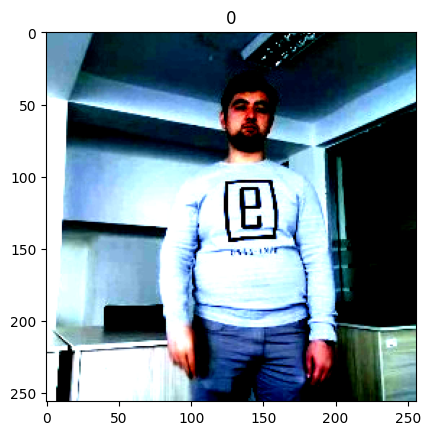

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


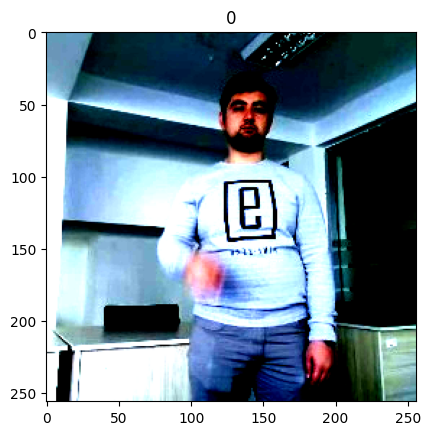

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


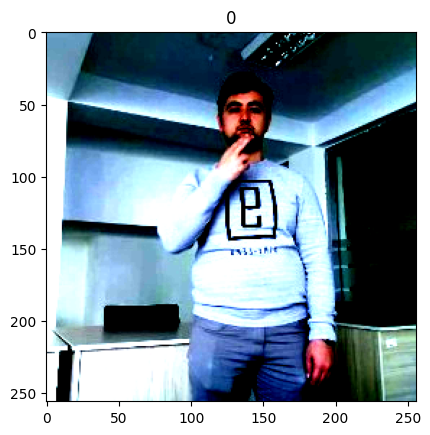

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


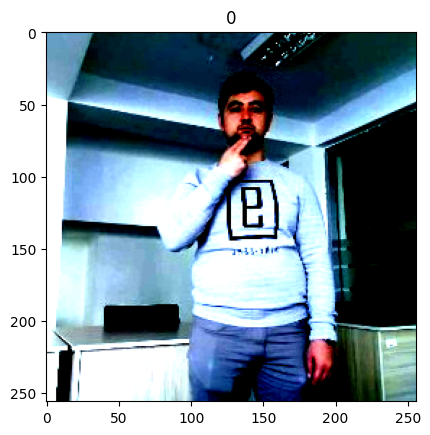

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


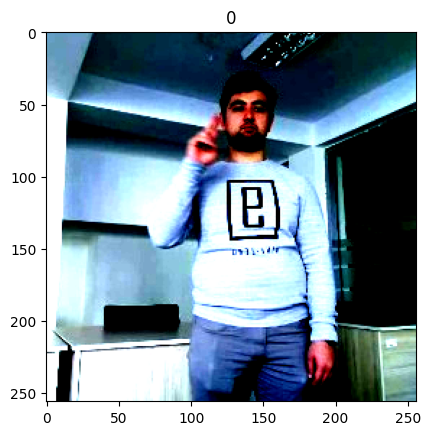

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


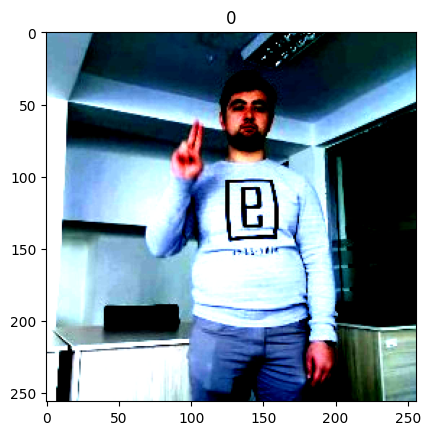

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


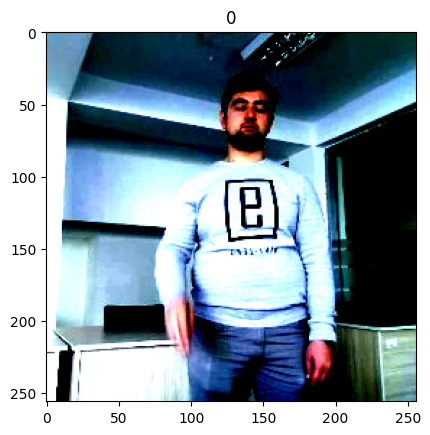

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


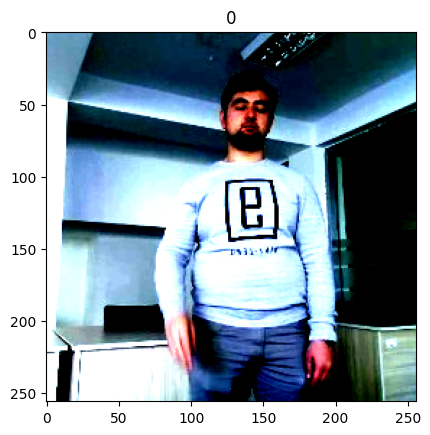

In [11]:
sample = ds[0]  # take first sample of dataset 
frames = sample[0]   # list of PIL images
label = sample[1]    # integer label

for image in frames:
    plt.imshow(image.permute(1, 2, 0))
    plt.title(label)
    plt.show()
    # plt.pause(1)

In [12]:
len(ds)

28132

# Lightning DataModule

In [13]:
class AutslDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int,
        num_workers: int,
        base: str = None
    ):
        super().__init__()

        self.save_hyperparameters()
        self.train_transform, self.val_transform = self._init_transforms()
        
        self.train_dataset = self._dataset('train', self.train_transform)
        self.val_dataset = self._dataset('val', self.val_transform)

    def _init_transforms(self):
        train_transform = frame_transforms['train']
        val_transform = frame_transforms['val']

        return train_transform, val_transform

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = self._dataset('train', self.train_transform)
            self.val_dataset = self._dataset('val', self.val_transform)

    def _dataset(self, ds_type, transform):
        match self.hparams.base:
            case 'np':
                return torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np8/{ds_type}',
                    loader=np.load,
                    transform=lambda x: apply_frame_transform(x, transform),
                    extensions=('.npy'), )
            case 'frames':
                return VideoFrameDataset(
                    root_path=f'data/autsl_frames/{ds_type}',
                    annotationfile_path=f'data/autsl_frames/{ds_type}/annotations.txt',
                    num_segments=8,
                    frames_per_segment=1,
                    imagefile_template='img_{:04d}.jpg',
                    transform=transform
                )
            case other:
                return AutslDataset(ds_type, transform=transform)

    def train_dataloader(self):
        return self._dataloader(self.train_dataset, train=True)

    def val_dataloader(self):
        return self._dataloader(self.val_dataset)

    def _dataloader(self, dataset, train=False):
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=train,
            num_workers=self.hparams.num_workers,
            drop_last=train,
            pin_memory=True
        )

# Model

In [14]:
EMB_SIZE = 256
NUM_CLASSES = 226

In [15]:
class FrameEncoder(nn.Module):
    def __init__(self, emb_dim, base_model_name=None, weights=None):
        super().__init__()
        self.emb_dim = emb_dim
        if base_model_name is not None:
            self.model = torchvision.models.get_model(base_model_name, weights=weights)
    
    def forward(self, X):
        return self.model(X)

class TemporalEncoder(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.out_dim = emb_dim
        self.model = None

    def forward(self, X):
        return self.model(X)

In [16]:
class EfficientNetEncoder(FrameEncoder):
    def __init__(self, emb_dim, base_model_name, weights: str = 'DEFAULT'):
        super().__init__(emb_dim, base_model_name, weights)
        self.model.classifier = nn.Sequential(
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(in_features=1280, out_features=self.emb_dim, bias=True)
        )

        
class AverageEncoder(TemporalEncoder):
    def __init__(self, emb_dim):
        super().__init__(emb_dim)

    def forward(self, X):
        return X.mean(dim=-2)


class VideoEncoder(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.frame_enc = EfficientNetEncoder(emb_dim, 'efficientnet_b1')
        self.temporal_enc = AverageEncoder(emb_dim)

    def forward(self, X):
        init_shape = X.shape
        frame_embs = self.frame_enc(X.flatten(0, 1)).reshape(*init_shape[:2], -1)
        video_emb = self.temporal_enc(frame_embs)
        return video_emb

class VideoClassifier(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        self.video_encoder = VideoEncoder(emb_dim)
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, X):
        emb = self.video_encoder(X)
        out = self.fc(emb)
        return out

# Lightning Module

In [17]:
class LITModule(pl.LightningModule):
    def __init__(
        self,
        emb_dim: float,
        drop_rate: float,
        eta_min: float,
        learning_rate: float,
        loss: str,
        max_epochs: int,
        num_classes: int,
        optimizer: str,
        scheduler: str,
        weight_decay: float,
        pretrained_path: bool
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = self._init_model(pretrained_path)

        self.loss_fn = self._init_loss_fn()

        self.metrics = self._init_metrics()

    def _init_model(self, pretrained_path=None):
        if pretrained_path is None:
            return VideoClassifier(
                emb_dim=self.hparams.emb_dim,
                num_classes=self.hparams.num_classes,
            )
        else:
            return torch.load(pretrained_path)

    def _init_loss_fn(self):
        if self.hparams.loss == "CELoss":
            return torch.nn.CrossEntropyLoss()
        else:
            raise ValueError(f"{self.hparams.loss} is not a valid loss function")

    def _init_metrics(self):
        metrics = {
                   # 'rocauc': MulticlassAUROC(self.hparams.num_classes),
                   'acc@1' : MulticlassAccuracy(self.hparams.num_classes, top_k=1),
                   'acc@5' : MulticlassAccuracy(self.hparams.num_classes, top_k=5),
                   'acc@10': MulticlassAccuracy(self.hparams.num_classes, top_k=10),
        }
        metric_collection = MetricCollection(metrics)

        return torch.nn.ModuleDict(
            {
                "train_metrics": metric_collection.clone(prefix="train_"),
                "val_metrics": metric_collection.clone(prefix="val_"),
            }
        )

    def configure_optimizers(self):
        optimizer = self._init_optimizer()

        scheduler = self._init_scheduler(optimizer)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
            },
        }

    def _init_optimizer(self):
        if self.hparams.optimizer == 'Adam':
            optimizer = torch.optim.Adam(
                params=self.parameters(),
                lr=self.hparams.learning_rate,
                weight_decay=self.hparams.weight_decay)
        else:
            raise ValueError(f"Unknown optimizer: {self.hparams.optimizer}")
        return optimizer

    def _init_scheduler(self, optimizer):
        if self.hparams.scheduler == "CosineAnnealingLR":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=self.hparams.max_epochs,
                eta_min=self.hparams.eta_min,
            )
        elif self.hparams.scheduler == "StepLR":
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer,
                step_size=self.hparams.max_epochs // 5,
                gamma=0.95,
            )
        else:
            raise ValueError(f"Unknown scheduler: {self.hparams.scheduler}")
        return scheduler

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        return self._shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        self._log_on_epoch_end('train')

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def validation_epoch_end(self, outputs):
        self._log_on_epoch_end('val')

    def predict_step(self, batch, batch_idx):
        _, labels, logits = self._forward_pass(batch, stage=None)
        preds = F.softmax(logits, dim=-1)
        return preds, labels

    def _shared_step(self, batch, stage):
        x, y, y_pred = self._forward_pass(batch)

        loss = self.loss_fn(y_pred, y)

        self.metrics[f"{stage}_metrics"](y_pred, y)

        self._log_on_step(stage, loss, batch_size=len(x))

        return loss

    def _forward_pass(self, batch):
        x, y = batch
        y = y.view(-1)
        y_pred = self(x)

        return x, y, y_pred

    def _log_on_step(self, stage, loss, batch_size):
        self.log(f"{stage}_loss", loss, batch_size=batch_size)

    def _log_on_epoch_end(self, stage):
        self.log_dict(self.metrics[f"{stage}_metrics"])

# Train

In [18]:
def load_logger_and_callbacks(
   metrics, patience, project
):
    logger, id_ = get_logger(metrics=metrics, project=project)
    callbacks = get_callbacks(
        id_=id_,
        mode=list(metrics.values())[0],
        monitor=list(metrics.keys())[0],
        patience=patience,
    )

    return logger, callbacks


def get_logger(metrics, project):
    logger = WandbLogger(project=project)
    id_ = logger.experiment.id

    for metric, summary in metrics.items():
        logger.experiment.define_metric(metric, summary=summary)

    return logger, id_


def get_callbacks(id_, mode, monitor, patience):
    callbacks = [
        EarlyStopping(monitor=monitor, mode=mode, patience=patience),
        LearningRateMonitor(),
    ]

    return callbacks

In [19]:
def train(
    accelerator: str = "gpu",
    batch_size: int = 32,
    devices: int = 1,
    drop_rate: float = 0.4,
    eta_min: float = 1e-6,
    learning_rate: float = 3e-4,
    loss: str = "CELoss",
    max_epochs: int = 1,
    emb_dim: int = EMB_SIZE,
    num_classes: int = NUM_CLASSES,
    num_workers: int = 8,
    optimizer: str = "Adam",
    patience: int = 20,
    precision: int = 32,
    project: str = "gestures",
    scheduler: str = "CosineAnnealingLR",
    weight_decay: float = 1e-6,
    pretrained_path='baseline.ckpt'
):
    pl.seed_everything(SEED, workers=True)

    data_module = AutslDataModule(
        batch_size=batch_size,
        num_workers=num_workers,
        base='frames'
    )

    module = LITModule(
        emb_dim=emb_dim,
        drop_rate=drop_rate,
        eta_min=eta_min,
        learning_rate=learning_rate,
        loss=loss,
        max_epochs=max_epochs,
        num_classes=num_classes,
        optimizer=optimizer,
        scheduler=scheduler,
        weight_decay=weight_decay,
        pretrained_path=pretrained_path
    )

    logger, callbacks = load_logger_and_callbacks(
        metrics={"val_loss": "min", "val_acc": "max", "val_f1": "max"},
        patience=patience,
        project=project,
    )

    trainer = pl.Trainer(
        accelerator=accelerator,
        benchmark=True,
        devices=devices,
        callbacks=callbacks,
        logger=logger,
        accumulate_grad_batches=1,
        log_every_n_steps=1,
        val_check_interval=0.2,
        max_epochs=max_epochs,
        max_steps=50,
        precision=precision,
        strategy="ddp" if devices > 1 else None,
        profiler=SimpleProfiler('./', 'prof')
    )

    trainer.fit(module, datamodule=data_module)
    # trainer.validate(module, datamodule=data_module)

    return module

In [20]:
from pytorch_lightning.profilers import AdvancedProfiler, SimpleProfiler
profiler = AdvancedProfiler(dirpath='prof_logs', filename='test')

In [ ]:
module = train()

Global seed set to 54


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | VideoClassifier  | 6.9 M 
1 | loss_fn | CrossEntropyLoss | 0     
2 | metrics | ModuleDict       | 0     
---------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
13.798    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
%%time
iter(train_dataloader)

In [ ]:
# torch.save(module.model, 'baseline.ckpt')